In [36]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.datasets import load_breast_cancer

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import missingno as msno
import random

In [37]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [38]:
titan_data_train = pd.read_csv("../data/titanic_datas/train.csv", index_col=0)
titan_data_test = pd.read_csv("../data/titanic_datas/test.csv", index_col=0)
test_final = pd.read_csv("../data/titanic_datas/gender_submission.csv", index_col=0)

In [39]:
titan_data_test = pd.concat([titan_data_test, test_final], axis= 1)

# 테스트 데이터에서의 남성의 생존은 0이다.
titan_data_test[(titan_data_test["Survived"] == 1) & (titan_data_test["Sex"] == "male")].sum().sum()

0.0

#### 결측확인

C:\Users\crazy\AppData\Local\Temp\ipykernel_708\1932477695.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  titan_data_train.corr()
C:\Users\crazy\AppData\Local\Temp\ipykernel_708\1932477695.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titan_data_train.corr(),
c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\IPython\core\events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly d

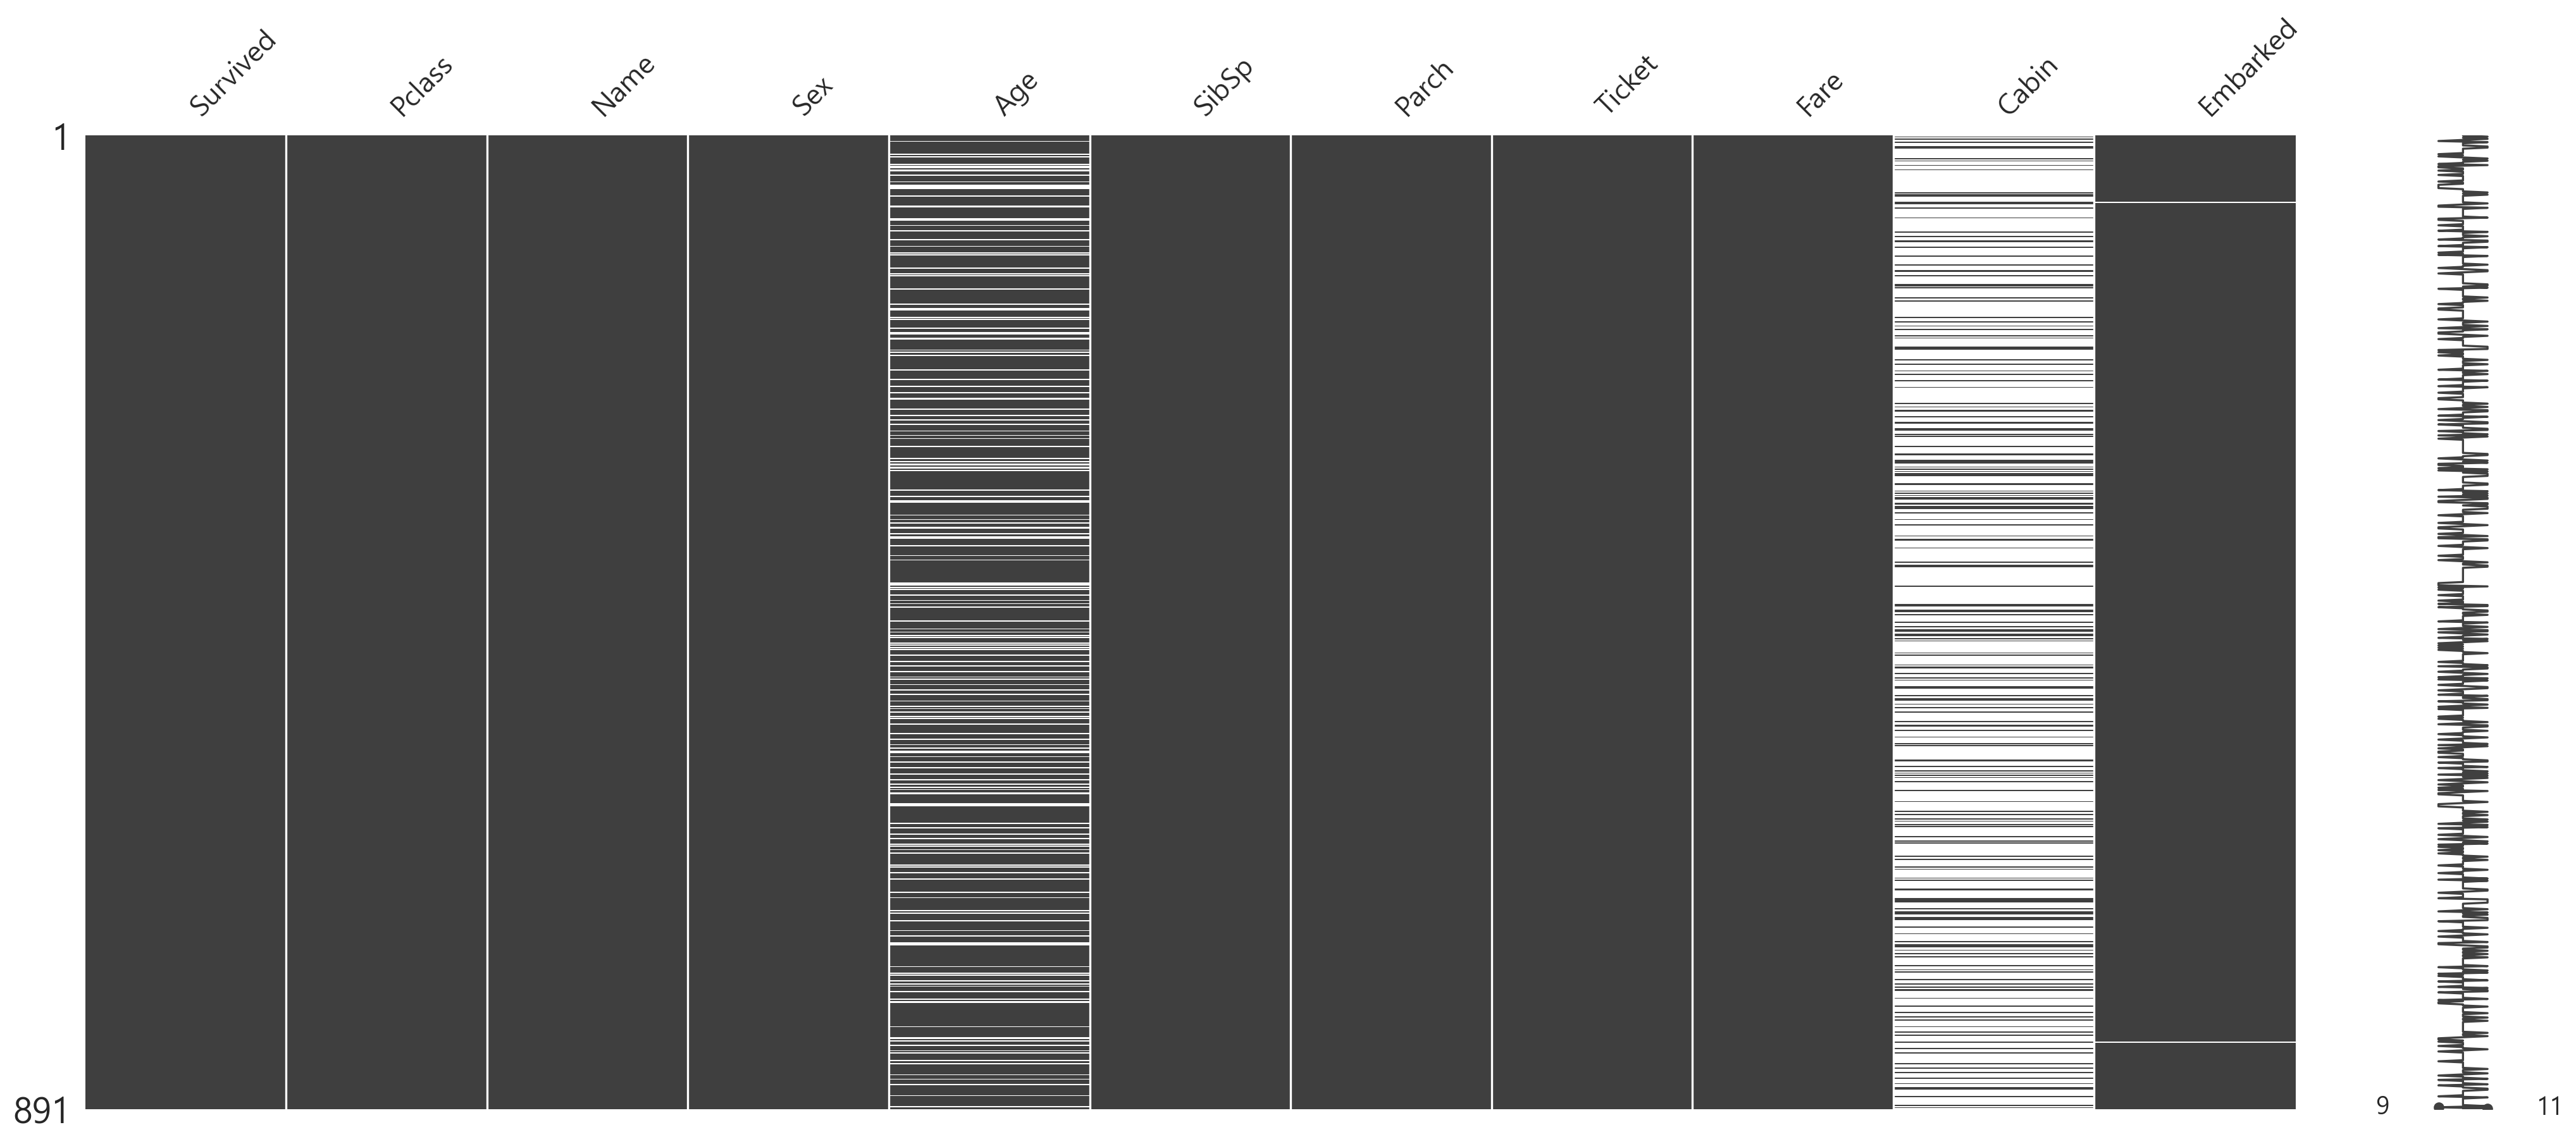

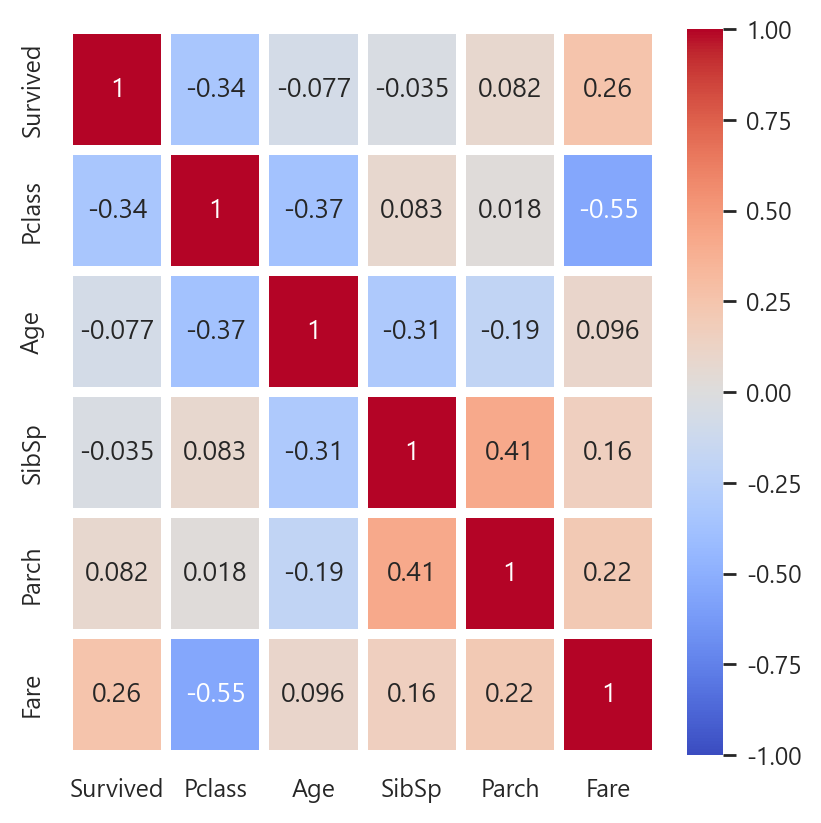

In [40]:
msno.matrix(titan_data_train)

# 1. age 의 결측값 - 채우기
# 2. cabin 의 결측값 - 너무 많아서 빼버리기로 결정

titan_data_train.corr()
fig, ax = plt.subplots(1,1,figsize = (4,4))
sns.heatmap(titan_data_train.corr(),
            annot=True,
            cmap="coolwarm",
            vmin=-1,vmax=1,
            linewidths=3);

#### 1. Parch 와 sibling 어쩃거나 가족수 이기 때문에 더한다.

In [41]:
titan_data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
titan_data_train["Embarked"].unique() # 승선한 항구 이름 : 항구 어디서 승선했는가는 큰 영향은 없을거 같다.

array(['S', 'C', 'Q', nan], dtype=object)

#### 데이터 타입 바꾸기

In [43]:
titan_data_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [44]:
# 서바이벌을 카테고리로 하기
titan_data_train["Survived"] = titan_data_train["Survived"].astype('category')
# 성별 카테고리화 하기
titan_data_train["sex_m"] = pd.get_dummies(titan_data_train[["Sex"]],drop_first=True)
titan_data_test["sex_m"] = pd.get_dummies(titan_data_test[["Sex"]],drop_first=True)
titan_data_train = titan_data_train.drop(columns=["Sex"])
titan_data_test = titan_data_test.drop(columns=["Sex"])

#### 나이 결측을 채우기 위한 작업

#### 10대 20대 ... 등으로 구분하기

In [45]:
# 가족수는 합치기
titan_data_train["familiys"] = titan_data_train["SibSp"] + titan_data_train["Parch"]
titan_data_test["familiys"] = titan_data_test["SibSp"] + titan_data_test["Parch"]
# 승선위치는 중요하지 않을 것 같다
titan_data_train = titan_data_train.drop(columns=["SibSp","Parch","Embarked"])
titan_data_test = titan_data_test.drop(columns=["SibSp","Parch","Embarked"])

In [46]:
# 클래스와 나이별 평균 구하기
age_dict = titan_data_train.groupby(["Pclass","sex_m"]).mean()["Age"].to_dict()
age_dict

C:\Users\crazy\AppData\Local\Temp\ipykernel_708\908778796.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  age_dict = titan_data_train.groupby(["Pclass","sex_m"]).mean()["Age"].to_dict()


{(1, 0): 34.61176470588235,
 (1, 1): 41.28138613861386,
 (2, 0): 28.722972972972972,
 (2, 1): 30.74070707070707,
 (3, 0): 21.75,
 (3, 1): 26.507588932806325}

In [47]:
# 나이별 성별별 클래스의 평균을 내어 각각 입력한다.
for i in range(1,4):
    for j in range(0,2):
        mask_train = (titan_data_train["Pclass"] == i) & (titan_data_train["sex_m"]) == j
        mask_test = (titan_data_test["Pclass"] == i) & (titan_data_test["sex_m"]) == j
        titan_data_train.loc[mask_train,"Age"] = titan_data_train.loc[mask_train, "Age"].fillna(age_dict[(i, j)])
        titan_data_test.loc[mask_test,"Age"] = titan_data_test.loc[mask_test, "Age"].fillna(age_dict[(i, j)])

In [48]:
titan_data_test.isna().sum()

Pclass        0
Name          0
Age           0
Ticket        0
Fare          1
Cabin       327
Survived      0
sex_m         0
familiys      0
dtype: int64

In [49]:
final_cols = ["Pclass","Age","Fare","sex_m","familiys"]
# final_cols = ["Pclass","Age","Fare","sex_m","familiys"]
# final_cols = ["sex_m","Age"]
# final_cols = ["Pclass","Age","sex_m","familiys"]

In [50]:
X = titan_data_train[final_cols].copy()  # 원본 데이터를 보호하기 위해 .copy() 사용

minmax = MinMaxScaler()
X.loc[:, ["Age", "Fare"]] = minmax.fit_transform(X.loc[:, ["Age", "Fare"]])
# X.loc[:, ["Age"]] = minmax.fit_transform(X.loc[:, ["Age"]])
y = titan_data_train["Survived"]

In [51]:
test_ = pd.concat([titan_data_test[final_cols],titan_data_test["Survived"]], axis=1).dropna(axis=0)
test_.loc[:, ["Age", "Fare"]] = minmax.fit_transform(test_.loc[:, ["Age", "Fare"]])
x_test = test_[final_cols]
y_test = test_["Survived"]

In [52]:
#train test

x_train = np.array(X, dtype=float)
y_train = np.array(y, dtype=float)
x_test = np.array(x_test, dtype=float)
y_test = np.array(y_test, dtype=float)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (891, 5)
y_train:  (891,)
x_test:  (417, 5)
y_test:  (417,)


In [53]:
# 랜덤 포레스트
model_RF = RandomForestClassifier(n_estimators=20,
                                  oob_score=True,
                                  max_depth=2)

model_RF.fit(x_train,y_train)
# pred_RF_train = model_RF.predict(x_train)
pred_RF = model_RF.predict(x_test)

# print("트레인 정확도:" , metrics.accuracy_score(y_train,pred_RF_train))
print("테스트 정확도:" , metrics.accuracy_score(y_test,pred_RF))


테스트 정확도: 0.9928057553956835


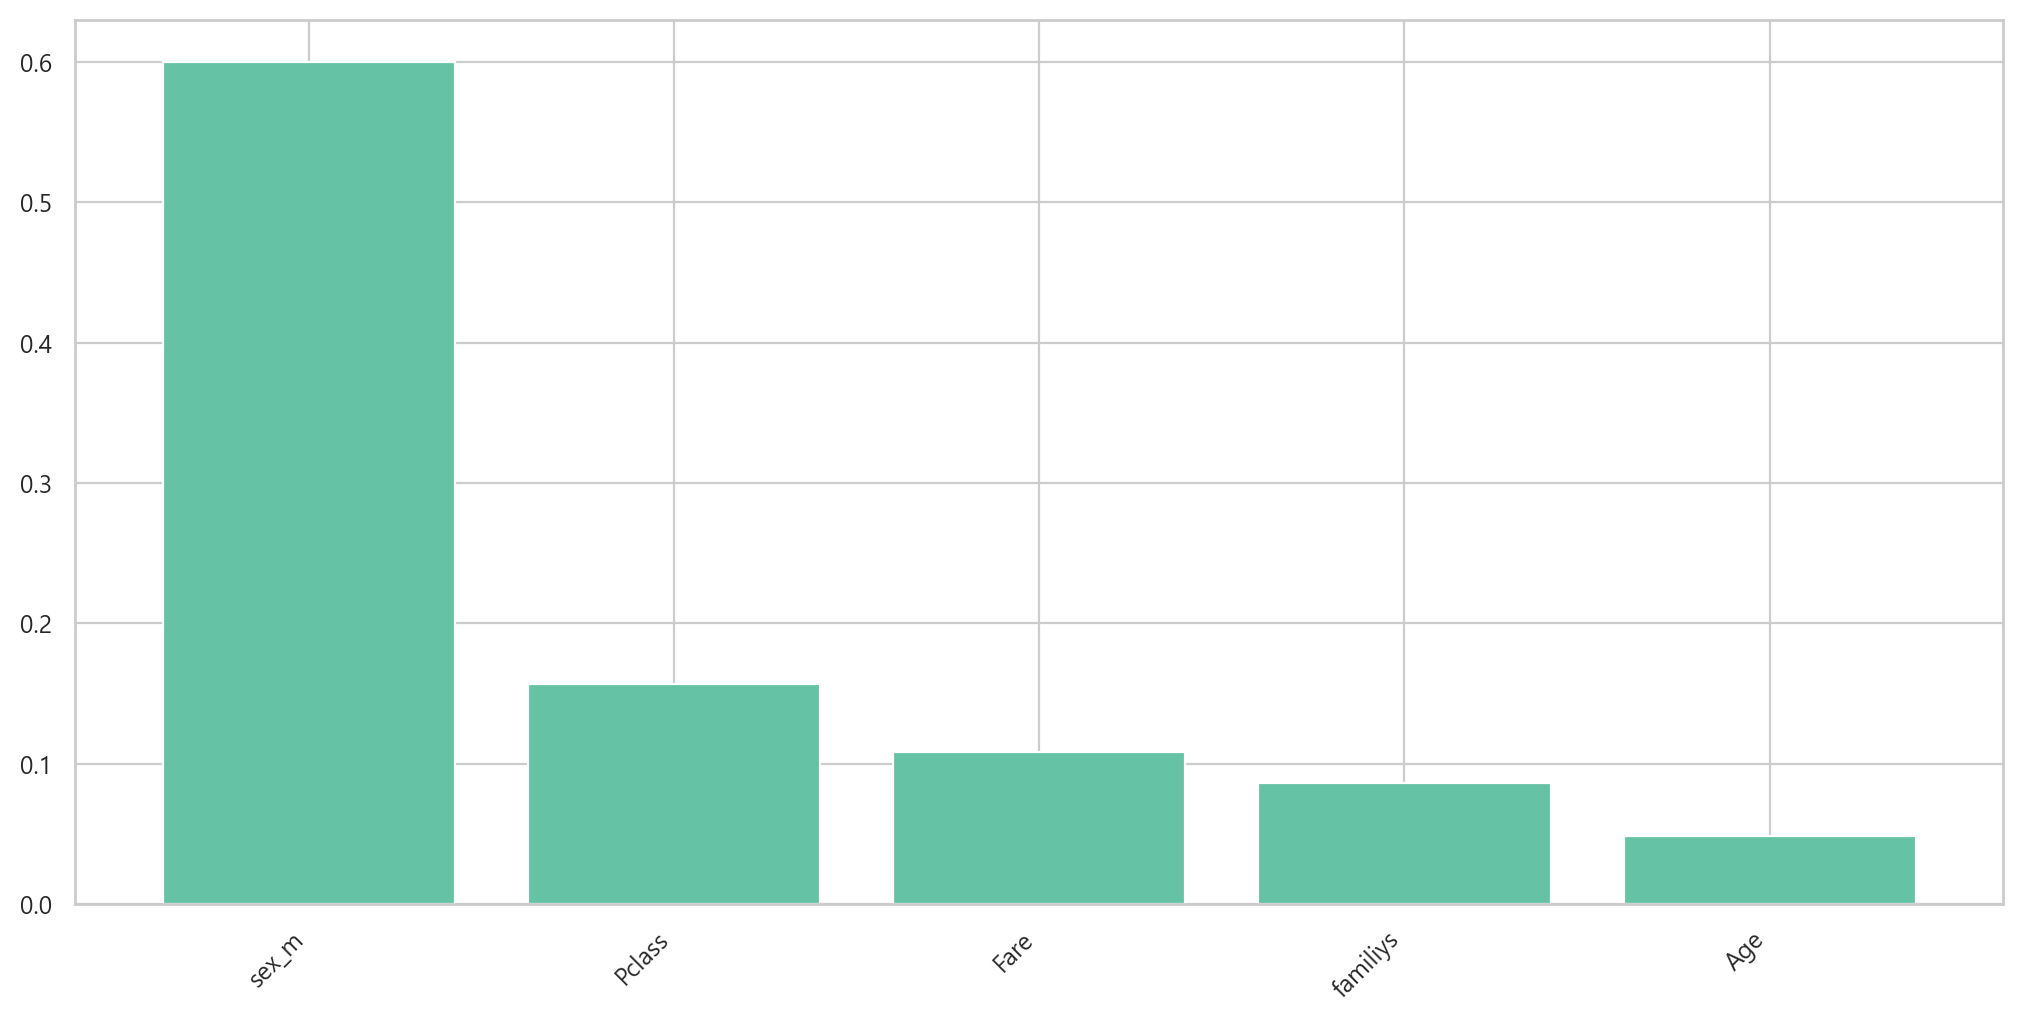

In [54]:
importances = {}
for i in range(len(X.columns)):
    importances[X.columns[i]] = model_RF.feature_importances_[i]

sorted_keys = sorted(importances, key=importances.get ,reverse=True)
sorted_values = [importances[key] for key in sorted_keys]

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(sorted_keys, sorted_values)
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 45);

In [55]:
X_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])
 
x_train_mixed, x_test_mixed, y_train_mixed, y_test_mixed = train_test_split(X_all,y_all,
                                                                            shuffle=True,
                                                                            test_size=0.3,
                                                                            stratify=y_all)

In [56]:
# 랜덤 포레스트
model_RF = RandomForestClassifier(n_estimators=20,
                                  oob_score=True,
                                  max_depth=2)

model_RF.fit(x_train_mixed,y_train_mixed)
# pred_RF_train = model_RF.predict(x_train)
pred_RF = model_RF.predict(x_test_mixed)

# print("트레인 정확도:" , metrics.accuracy_score(y_train,pred_RF_train))
print("테스트 정확도:" , metrics.accuracy_score(y_test_mixed,pred_RF))


테스트 정확도: 0.8524173027989822


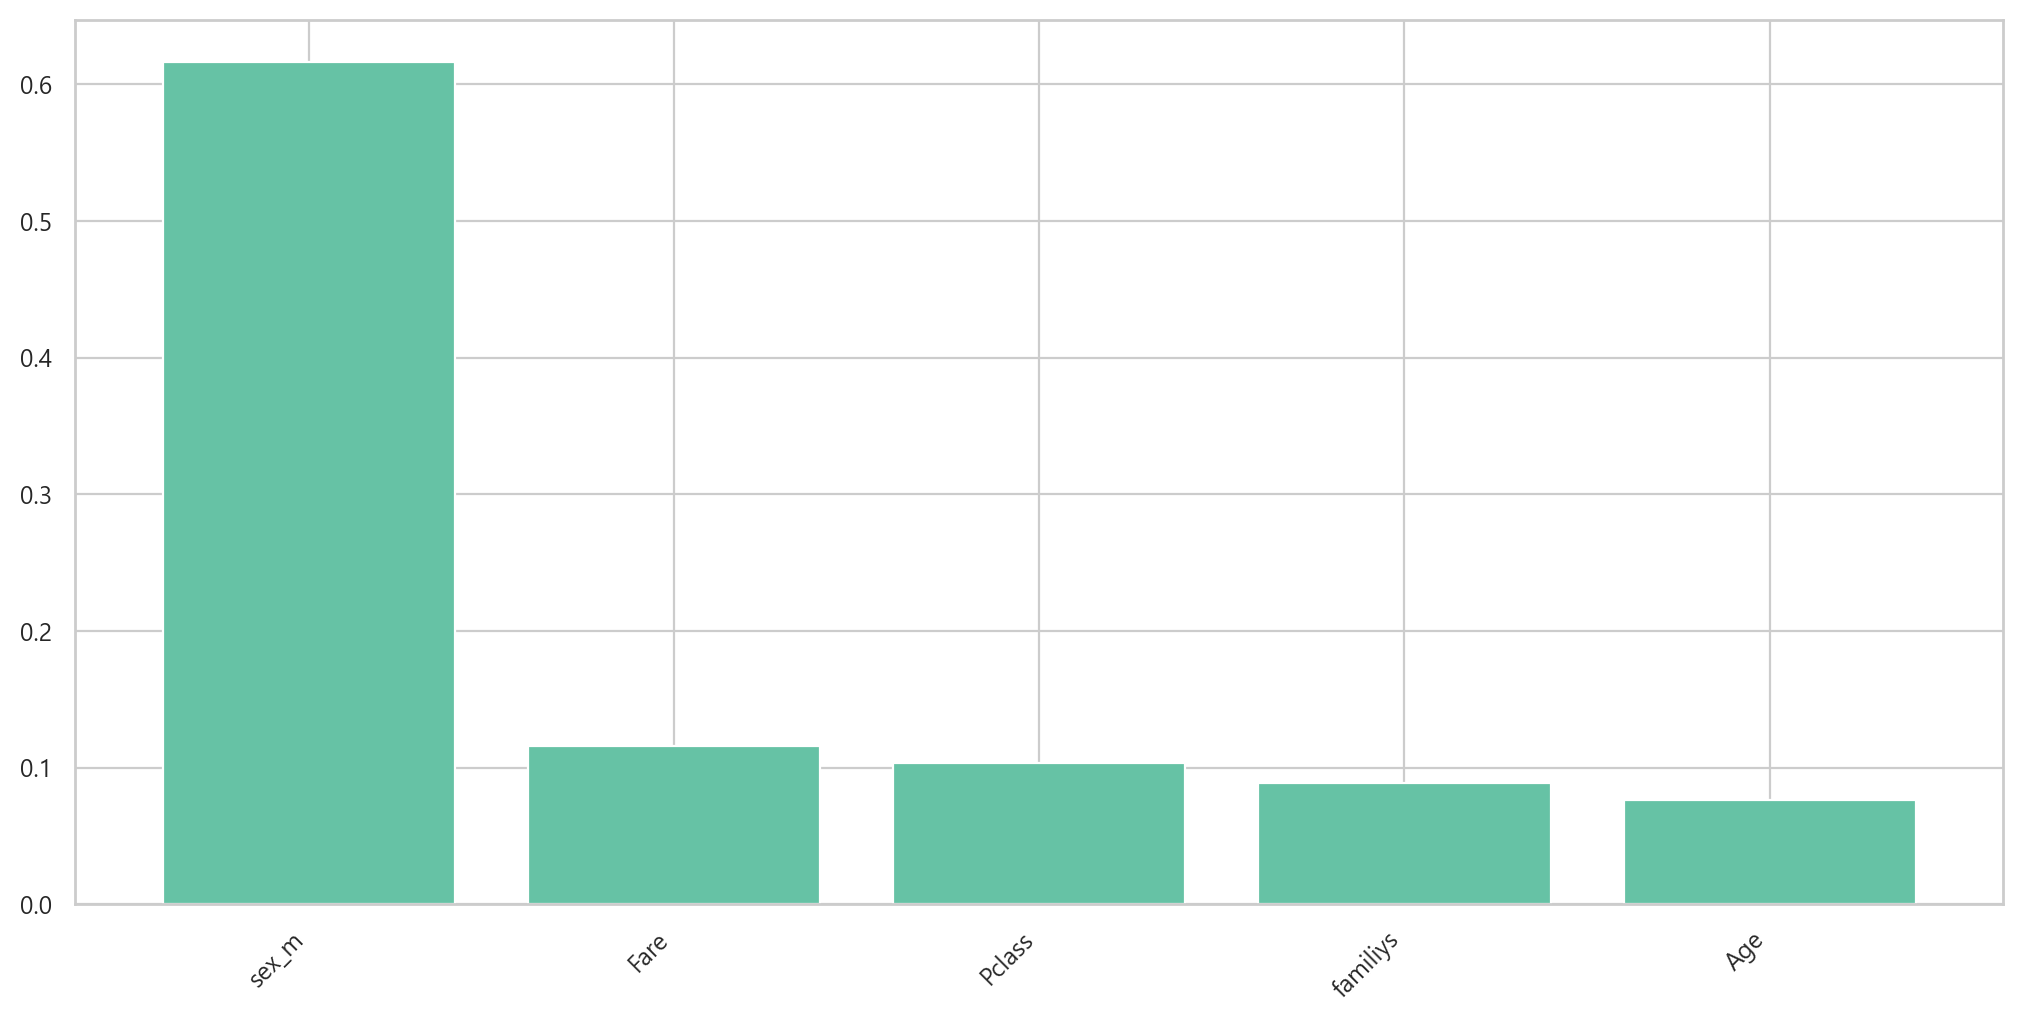

In [57]:
importances = {}
for i in range(len(X.columns)):
    importances[X.columns[i]] = model_RF.feature_importances_[i]

sorted_keys = sorted(importances, key=importances.get ,reverse=True)
sorted_values = [importances[key] for key in sorted_keys]

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(sorted_keys, sorted_values)
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 45);

##### 트레인 테스트 섞어서 다시

In [58]:
x_train_mixed, x_test_mixed, y_train_mixed, y_test_mixed

(array([[2.00000000e+00, 2.08343805e-01, 2.34224401e-02, 0.00000000e+00,
         0.00000000e+00],
        [3.00000000e+00, 4.49861774e-02, 6.10447345e-02, 1.00000000e+00,
         6.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 5.85561003e-02, 1.00000000e+00,
         0.00000000e+00],
        ...,
        [3.00000000e+00, 4.14677055e-03, 3.75896982e-02, 0.00000000e+00,
         3.00000000e+00],
        [2.00000000e+00, 5.47625031e-01, 5.07486202e-02, 1.00000000e+00,
         1.00000000e+00],
        [3.00000000e+00, 3.46569490e-01, 1.54685698e-02, 1.00000000e+00,
         2.00000000e+00]]),
 array([[3.        , 0.39337993, 0.0135655 , 0.        , 0.        ],
        [1.        , 0.33400352, 0.1036443 , 1.        , 1.        ],
        [3.        , 0.42965274, 0.01541158, 1.        , 0.        ],
        ...,
        [2.        , 0.28373963, 0.02537431, 1.        , 0.        ],
        [3.        , 0.45419708, 0.01571255, 1.        , 0.        ],
        [3.        , 0.65712

In [59]:
def ran_search(params,iters,model):
    model_base = RandomizedSearchCV(model,
                              params,
                              n_iter= iters,
                              cv = 5,
                              return_train_score=True,
                              n_jobs = -1,
                              random_state=97)
    # print("현재 모델명:" , type(model))
    model_base.fit(x_train_mixed, y_train_mixed)

    print("최상 매개변수:", model_base.best_params_)
    print("최고 정확도:", model_base.best_score_)
    
    best_model = model_base.best_estimator_
    best_pred = best_model.predict(x_test_mixed)
    print("테스트 정확도", metrics.accuracy_score(best_pred,y_test_mixed))

In [60]:
def grid_search(params, model):
    model_grid = GridSearchCV(model,
                              params,
                              cv=5,
                              return_train_score=True,)
    model_grid.fit(x_train_mixed,y_train_mixed)

    print("최고 매개변수",model_grid.best_params_)
    print("최고 정확도",model_grid.best_score_)

    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test_mixed)
    print("테스트에 대한 정확도",metrics.accuracy_score(pred_best, y_test_mixed))

In [61]:
#knn
params = {"n_neighbors" : [1,2,3,4],
          "weights" : ["uniform","distance"]}
grid_search(params,KNeighborsClassifier());

최고 매개변수 {'n_neighbors': 4, 'weights': 'uniform'}
최고 정확도 0.8524590163934427
테스트에 대한 정확도 0.8447837150127226


In [62]:
#tree
params = {"max_depth" : [2,3,4,5,6,10,20],
          "splitter" : ["best","random"]}
grid_search(params,DecisionTreeClassifier());

최고 매개변수 {'max_depth': 4, 'splitter': 'best'}
최고 정확도 0.8775956284153004
테스트에 대한 정확도 0.8447837150127226


In [63]:
#RandomForest
params = {
          "n_estimators" : np.arange(10, 800, 10),
          "max_depth" : [2,3,4,5,6,10,20],
          "max_features" : [2,3,4,5],}
ran_search(params,100,RandomForestClassifier(oob_score=False));

최상 매개변수: {'n_estimators': 240, 'max_features': 2, 'max_depth': 5}
최고 정확도: 0.8808743169398907
테스트 정확도 0.8575063613231552


In [64]:
params = {
    "max_depth": [1, 2, 3, 4 ,5, 6, 10, 20],
    "learning_rate": np.arange(0.07, 0.5, 0.005),
    "n_estimators": np.arange(10, 800, 10),
}
ran_search(params,100,XGBClassifier(booster = "gbtree",
                     objective = "binary:logistic"));

최상 매개변수: {'n_estimators': 90, 'max_depth': 2, 'learning_rate': 0.46500000000000036}
최고 정확도: 0.881967213114754
테스트 정확도 0.8549618320610687


# 딥러닝 x

In [65]:
random.seed(42)

model_dnn = Sequential()
model_dnn.add(Dense(8,
                       kernel_initializer= 'he_normal', # he_nomal
                       activation = "relu",
                       input_shape = (5, )),)

model_dnn.add(Dense(16,kernel_initializer= 'he_normal',activation = "relu",))
model_dnn.add(Dense(8,kernel_initializer= 'he_normal',activation = "relu",))
model_dnn.add(Dense(1,kernel_initializer= 'he_normal',activation = "sigmoid",))

model_dnn.summary()

adam = Adam(learning_rate=0.01)
model_dnn.compile(loss = "binary_crossentropy",
                     optimizer=adam,
                     metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 48        
                                                                 
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [66]:
early_s = EarlyStopping(patience=2, # 보통 3 정도 
                        restore_best_weights=True)

history = model_dnn.fit(x_train_mixed, y_train_mixed,
                                    epochs=300,
                                    batch_size = 200,
                                    validation_split=0.2,
                                    callbacks=[early_s],
                                    verbose = 1)

Epoch 1/300
4/4 [==============================] - 1s 59ms/step - loss: 0.6650 - accuracy: 0.6079 - val_loss: 0.5931 - val_accuracy: 0.6776
Epoch 2/300
4/4 [==============================] - 0s 28ms/step - loss: 0.6255 - accuracy: 0.6079 - val_loss: 0.5682 - val_accuracy: 0.6776
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 0.6005 - accuracy: 0.6079 - val_loss: 0.5349 - val_accuracy: 0.6776
Epoch 4/300
4/4 [==============================] - 0s 16ms/step - loss: 0.5759 - accuracy: 0.6079 - val_loss: 0.5071 - val_accuracy: 0.6776
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 0.5453 - accuracy: 0.6325 - val_loss: 0.4847 - val_accuracy: 0.7650
Epoch 6/300
4/4 [==============================] - 0s 14ms/step - loss: 0.5175 - accuracy: 0.7541 - val_loss: 0.4488 - val_accuracy: 0.8415
Epoch 7/300
4/4 [==============================] - 0s 13ms/step - loss: 0.4947 - accuracy: 0.8265 - val_loss: 0.4335 - val_accuracy: 0.8361
Epoch 8/300
4/4 [===

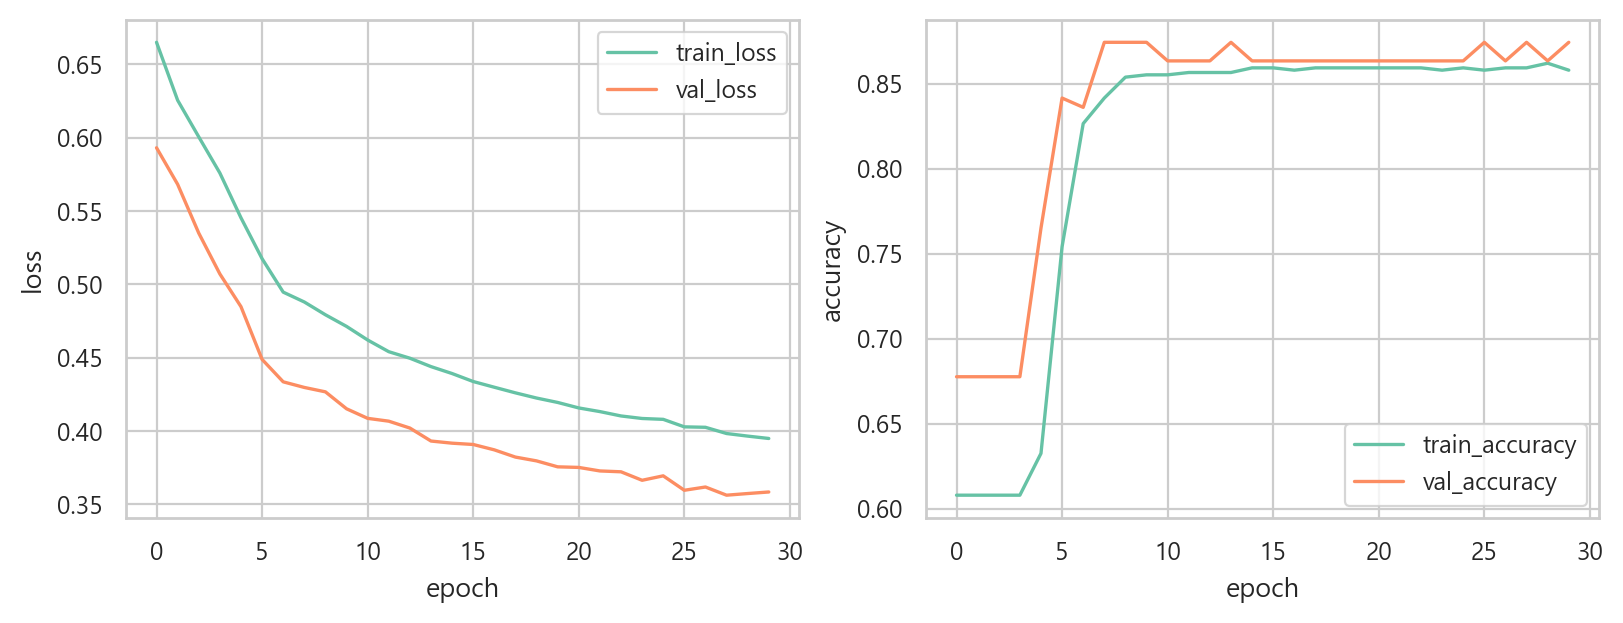

In [67]:
fig, ax = plt.subplots(1,2, figsize = (8,3))

ax[0].plot(history.history["loss"] , label = "train_loss")
ax[0].plot(history.history["val_loss"] , label = "val_loss")
ax[0].set(xlabel = "epoch", ylabel= "loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"] , label = "train_accuracy")
ax[1].plot(history.history["val_accuracy"] , label = "val_accuracy")
ax[1].set(xlabel = "epoch", ylabel= "accuracy")
ax[1].legend();